In [1]:
import requests
import json
from random import random

# Define the base URL of the API
base_url = "http://localhost:3000"

# Send a vector to the '/insert' endpoint
def insert_vector(vector_data):
    url = f"{base_url}/vector/insert"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, data=json.dumps(vector_data))
    
    if response.status_code == 200:
        print(f"Response from '/insert': {response.json()}")
    else:
        print(f"Error: {response.status_code}")

def insert_batch_vector(vector_data):
    url = f"{base_url}/vector/insert_batch"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, data=json.dumps(vector_data))
    
    if response.status_code == 200:
        print(f"Response from '/insert': {response.json()}")
    else:
        print(f"Error: {response.status_code}")

# Request metadata from the '/metadata' endpoint
def get_metadata():
    url = f"{base_url}/metadata"
    headers = {'Content-Type': 'application/json'}
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        return json.loads(response.json().replace("(", "[").replace(")", "]"))
    else:
        print(f"Error: {response.status_code}")

# KNN Query function
def knn_query(vector, k):
    url = f"{base_url}vector/knn"
    payload = {"vector": vector, "k": k}
    headers = {'Content-Type': 'application/json'}

    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        print(f"Response from 'vector/knn': {response.json()}")
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        return None
def get_vectors_by_partition(partition_ids):
    url = f"{base_url}/vector/from_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": partition_ids
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_edges_for_partition(partition_id):
    url = f"{base_url}/graph/intra/by_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": [partition_id]
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_inter_edges_for_partition(partition_id):
    url = f"{base_url}/graph/inter/by_partitions"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "ids": [partition_id]
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

# Example: Sending a vector to the API
vector_data = {
    "vector": [random(), random()]  # Example vector data
}

# Example: Requesting metadata
# get_metadata()
def generate_clusters(threshold):
    url = f"{base_url}/cluster/new"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "threshold": threshold
    }
    
    response = requests.put(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None
def get_clusters(threshold):
    url = f"{base_url}/cluster"
    headers = {'Content-Type': 'application/json'}
    
    payload = {
        "threshold": threshold
    }
    
    response = requests.get(url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

In [2]:
from random import uniform, gauss
from math import sqrt
from dataclasses import dataclass
from typing import List

@dataclass
class Cluster:
    center: List[float]
    radius: float
    num_points: int

def generate_random_points_nd(center: List[float], radius: float, num_points: int) -> List[List[float]]:
    """
    Generates random points within a given radius around a center point in n-dimensional space.
    """
    n = len(center)
    points = []

    for _ in range(num_points):
        # Generate a random direction
        random_direction = [gauss(0, 1) for _ in range(n)]
        norm = sqrt(sum(x ** 2 for x in random_direction))
        unit_vector = [x / norm for x in random_direction]
        
        # Generate a random distance within the radius
        random_distance = uniform(0, radius)
        
        # Compute the random point
        random_point = [center[i] + random_distance * unit_vector[i] for i in range(n)]
        points.append(random_point)

    return points

In [5]:
insert_vector({
    "vector": [random(), random()]  # Example vector data
})

Response from '/insert': {'vector_id': '401bb6f2-3c61-4995-8922-6d23f94a6f02'}


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def plot_partition_graph(partitions, edges, meta_data, inter_partition_edges=None, cluster_data=None, show=True):
    """
    Plot a graph where nodes represent vectors in partitions and edges represent connections between them.

    Args:
        partitions: List of tuples [(PartitionId: str, [(VectorId: str, [float, float])])]
        edges: List of lists of tuples [(VectorId: str, VectorId: str, weight: float)]
        meta_data: List of tuples [(PartitionId: str, size: int, centroid: [float, float])]
        inter_partition_edges: List of tuples [(VectorId: str, VectorId: str, weight: float)]
        cluster_data: Dict[str, List[str]] - Mapping of Cluster Ids to lists of Vector Ids
    """
    plt.figure(figsize=(12, 8))

    # Generate distinct colors for each partition
    num_partitions = len(partitions)
    colors = plt.cm.get_cmap('tab20', num_partitions)

    # Extract centroids and colors for partitions
    centroids = np.array([centroid for _, _, centroid in meta_data])
    partition_colors = [colors(i) for i in range(num_partitions)]

    # Create a KDTree for efficient nearest neighbor search
    tree = KDTree(centroids)

    # Set up grid points for background coloring
    vector_coords = np.concatenate([np.array([vector_data[1] for vector_data in vectors]) for _, vectors in partitions])
    x_min, x_max = vector_coords[:, 0].min(), vector_coords[:, 0].max()
    y_min, y_max = vector_coords[:, 1].min(), vector_coords[:, 1].max()

    x_dist = (x_max - x_min) * 0.1
    x_min, x_max = x_min - x_dist, x_max + x_dist
    y_dist = (y_max - y_min) * 0.1
    y_min, y_max = y_min - y_dist, y_max + y_dist

    x_vals = np.linspace(x_min, x_max, 500)
    y_vals = np.linspace(y_min, y_max, 500)
    xv, yv = np.meshgrid(x_vals, y_vals)
    grid_points = np.c_[xv.ravel(), yv.ravel()]

    # Find nearest centroid for each grid point
    _, indices = tree.query(grid_points)
    
    # Color the background based on the nearest centroid
    background_colors = np.array([partition_colors[idx] for idx in indices])
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c=background_colors, marker='s', s=1, alpha=0.1)

    # Plot partition labels behind everything
    for partition_index, (partition_id, _, centroid) in enumerate(meta_data):
        plt.text(
            centroid[0], centroid[1], partition_id, 
            fontsize=12, color='gray', alpha=0.3, 
            ha='center', va='center', zorder=-1
        )



    # Plot nodes for each partition
    node_positions = {}
    for partition_index, (partition_id, vectors) in enumerate(partitions):
        partition_color = partition_colors[partition_index]
        vector_coords = np.array([vector_data[1] for vector_data in vectors])
        if len(vector_coords) > 0:
            plt.scatter(
                vector_coords[:, 0], 
                vector_coords[:, 1], 
                s=40, 
                c=[partition_color], 
                edgecolors='k', 
                marker='x', 
                label=f"Partition {partition_id}"
            )
            for vector_id, coord in zip([vec[0] for vec in vectors], vector_coords):
                node_positions[vector_id] = coord
    
    
    # Render cluster circles
    if cluster_data:
        cluster_colors = plt.cm.get_cmap('rainbow', len(cluster_data))
        for i, (cluster_id, vector_ids) in enumerate(cluster_data.items()):
            cluster_color = cluster_colors(i)
            for vector_id in vector_ids:
                if vector_id in node_positions:
                    pos = node_positions[vector_id]
                    plt.scatter(
                        pos[0], pos[1], 
                        s=100, 
                        color=cluster_color, 
                        edgecolors='none', 
                        alpha=0.3, 
                        marker='o'
                    )

    # Plot centroids from meta_data
    for partition_index, (partition_id, size, centroid) in enumerate(meta_data):
        plt.scatter(
            centroid[0], centroid[1], 
            s=max(10, size * 5), 
            c=[partition_colors[partition_index]], 
            edgecolors='white', 
            marker='o', 
            label=f"Centroid for {partition_id}"
        )

    # Plot edges within partitions
    for partition_edges in edges:
        for vector_id1, vector_id2, weight in partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                plt.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    'k--', 
                    linewidth=0.5, 
                    alpha=0.7
                )

    # Plot inter-partition edges (solid lines)
    if inter_partition_edges:
        for vector_id1, vector_id2, weight in inter_partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                plt.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    color='purple', 
                    linewidth=0.5, 
                    alpha=0.9
                )

    plt.title("Partition Graph with Weighted Edges and Metadata Centroids")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.show()


In [4]:
def plot_partition_graph_gif(ax, partitions, edges, meta_data, inter_partition_edges=None, cluster_data=None):
    ax.clear()  # Clear the existing axes instead of creating a new figure
    """
    Plot a graph where nodes represent vectors in partitions and edges represent connections between them.

    Args:
        partitions: List of tuples [(PartitionId: str, [(VectorId: str, [float, float])])]
        edges: List of lists of tuples [(VectorId: str, VectorId: str, weight: float)]
        meta_data: List of tuples [(PartitionId: str, size: int, centroid: [float, float])]
        inter_partition_edges: List of tuples [(VectorId: str, VectorId: str, weight: float)]
        cluster_data: Dict[str, List[str]] - Mapping of Cluster Ids to lists of Vector Ids
    """
    # ax.figure(figsize=(12, 8))

    # Generate distinct colors for each partition
    num_partitions = len(partitions)
    colors = plt.cm.get_cmap('tab20', num_partitions)

    # Extract centroids and colors for partitions
    centroids = np.array([centroid for _, _, centroid in meta_data])
    partition_colors = [colors(i) for i in range(num_partitions)]

    # Create a KDTree for efficient nearest neighbor search
    tree = KDTree(centroids)

    # Set up grid points for background coloring
    vector_coords = np.concatenate([np.array([vector_data[1] for vector_data in vectors]) for _, vectors in partitions])
    x_min, x_max = vector_coords[:, 0].min(), vector_coords[:, 0].max()
    y_min, y_max = vector_coords[:, 1].min(), vector_coords[:, 1].max()

    x_dist = (x_max - x_min) * 0.1
    x_min, x_max = x_min - x_dist, x_max + x_dist
    y_dist = (y_max - y_min) * 0.1
    y_min, y_max = y_min - y_dist, y_max + y_dist

    x_vals = np.linspace(x_min, x_max, 500)
    y_vals = np.linspace(y_min, y_max, 500)
    xv, yv = np.meshgrid(x_vals, y_vals)
    grid_points = np.c_[xv.ravel(), yv.ravel()]

    # Find nearest centroid for each grid point
    _, indices = tree.query(grid_points)
    
    # Color the background based on the nearest centroid
    background_colors = np.array([partition_colors[idx] for idx in indices])
    ax.scatter(grid_points[:, 0], grid_points[:, 1], c=background_colors, marker='s', s=1, alpha=0.1)

    # Plot partition labels behind everything
    for partition_index, (partition_id, _, centroid) in enumerate(meta_data):
        ax.text(
            centroid[0], centroid[1], partition_id, 
            fontsize=12, color='gray', alpha=0.3, 
            ha='center', va='center', zorder=-1
        )



    # Plot nodes for each partition
    node_positions = {}
    for partition_index, (partition_id, vectors) in enumerate(partitions):
        partition_color = partition_colors[partition_index]
        vector_coords = np.array([vector_data[1] for vector_data in vectors])
        if len(vector_coords) > 0:
            ax.scatter(
                vector_coords[:, 0], 
                vector_coords[:, 1], 
                s=40, 
                c=[partition_color], 
                edgecolors='k', 
                marker='x', 
                label=f"Partition {partition_id}"
            )
            for vector_id, coord in zip([vec[0] for vec in vectors], vector_coords):
                node_positions[vector_id] = coord
    
    
    # Render cluster circles
    if cluster_data:
        cluster_colors = plt.cm.get_cmap('rainbow', len(cluster_data))
        for i, (cluster_id, vector_ids) in enumerate(cluster_data.items()):
            cluster_color = cluster_colors(i)
            for vector_id in vector_ids:
                if vector_id in node_positions:
                    pos = node_positions[vector_id]
                    ax.scatter(
                        pos[0], pos[1], 
                        s=100, 
                        color=cluster_color, 
                        edgecolors='none', 
                        alpha=0.3, 
                        marker='o'
                    )

    # Plot centroids from meta_data
    for partition_index, (partition_id, size, centroid) in enumerate(meta_data):
        ax.scatter(
            centroid[0], centroid[1], 
            s=max(10, size * 5), 
            c=[partition_colors[partition_index]], 
            edgecolors='white', 
            marker='o', 
            label=f"Centroid for {partition_id}"
        )

    # Plot edges within partitions
    for partition_edges in edges:
        for vector_id1, vector_id2, weight in partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                ax.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    'k--', 
                    linewidth=0.5, 
                    alpha=0.7
                )

    # Plot inter-partition edges (solid lines)
    if inter_partition_edges:
        for vector_id1, vector_id2, weight in inter_partition_edges:
            if vector_id1 in node_positions and vector_id2 in node_positions:
                pos1 = node_positions[vector_id1]
                pos2 = node_positions[vector_id2]
                ax.plot(
                    [pos1[0], pos2[0]], 
                    [pos1[1], pos2[1]], 
                    color='purple', 
                    linewidth=max(0.5, weight * 0.1), 
                    alpha=0.9
                )

    ax.set_title("Partition Graph with Weighted Edges and Metadata Centroids")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(True)
    # ax.gca().set_aspect('equal', adjustable='box')

In [24]:
get_metadata()

[['5ca9848c-eeaa-4719-9599-6071b6339f9f', 1, [0.22492239, 0.6885963]]]

C:\Users\hasin\AppData\Local\Temp\ipykernel_32424\3267568343.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)
C:\Users\hasin\AppData\Local\Temp\ipykernel_32424\3267568343.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


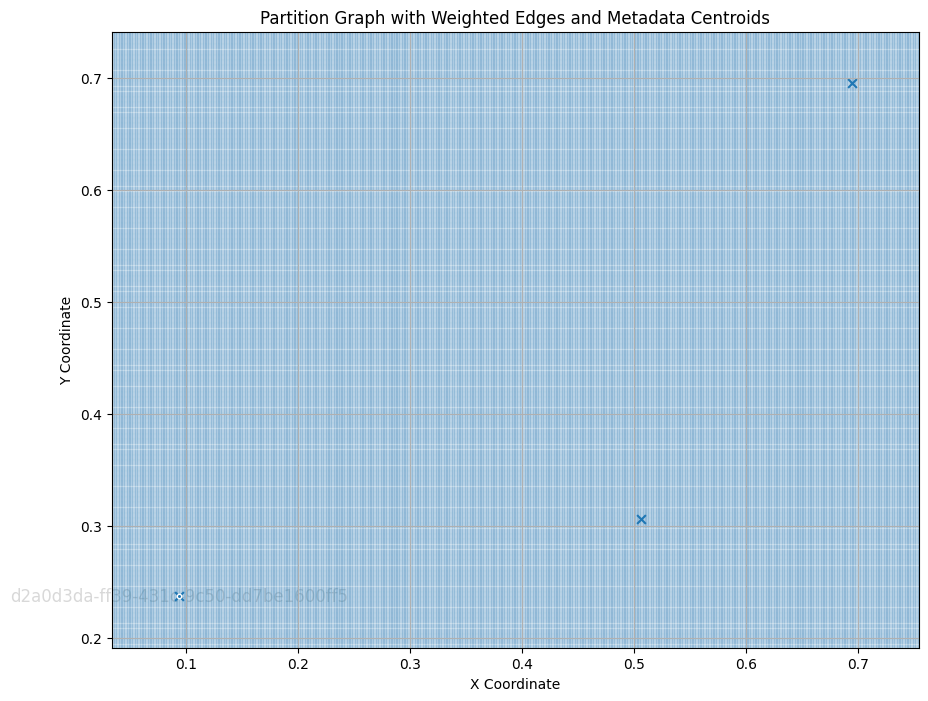

In [8]:
from functional import seq
meta_data = get_metadata()
partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()
plot_partition_graph(partitions, edges, meta_data, inter_edges)

# Large Input test

In [4]:
vectors = [[random()*100., random()*100.] for i in range(990_000)]

In [7]:
# Define clusters
# clusters = [
#     Cluster(center=[0.5, 0.5], radius=0.05, num_points=40),  # Dense cluster
#     Cluster(center=[0., 0.], radius=.5, num_points=100*4),    # Sparse cluster
#     Cluster(center=[0.25, 0.75], radius=0.15, num_points=50*4),   # Medium density
#     Cluster(center=[0.9, 0.1], radius=0.1, num_points=80*4),    # Mixed density
# ]

clusters = [
    Cluster(center=[1.5, 0.5], radius=0.4, num_points=80),   # Dense cluster
    Cluster(center=[0., 0.], radius=0.6, num_points=20),     # Sparse cluster
    Cluster(center=[3.25, 3.75], radius=0.7, num_points=40), # Medium density
    Cluster(center=[3.1, 1.1], radius=0.5, num_points=50),   # Mixed density
    Cluster(center=[-2.0, 2.5], radius=1.0, num_points=70),  # Large spread
    Cluster(center=[2.0, -1.0], radius=0.3, num_points=30),  # Small tight cluster
    Cluster(center=[5.5, 2.0], radius=0.8, num_points=60),   # Another medium spread
    Cluster(center=[-1.0, -2.0], radius=0.9, num_points=45), # Low-density, wide range
]

# Add a composite cluster with sub-clusters to form a non-circular shape
composite_cluster_centers = [
    [3.4, 0.4],
    [3.5, 0.5],
    [3.6, 0.6],
    [3.7, 0.7],
]
composite_points = []

for sub_center in composite_cluster_centers:
    points = generate_random_points_nd(sub_center, (0.1**2+0.1**2)**0.5, 50*4)  # Smaller clusters
    composite_points.extend(points)

vectors = []

# Append the composite cluster points
# vectors.extend(composite_points)

# Generate points for regular clusters
for cluster in clusters:
    points = generate_random_points_nd(cluster.center, cluster.radius, cluster.num_points)
    vectors.extend(points)


print(f"Generated {len(vectors)} points including a non-circular composite cluster.")

Generated 395 points including a non-circular composite cluster.


In [8]:
from random import shuffle
shuffle(vectors)
vectors

[[3.1323225646663846, 1.217745316606933],
 [-2.375728103774869, 2.6822004016706487],
 [5.413783486507939, 2.1425579771146532],
 [4.899658339496198, 2.205107614787284],
 [-1.0007417304806288, -1.400617149178966],
 [-1.8305824948532146, 1.801331277578318],
 [3.040622872848338, 1.1514623906160737],
 [-0.23955259122764075, -0.19793912201173453],
 [-1.3271950513899307, -1.9983246487260518],
 [-0.3919480357365588, -1.828539344741807],
 [1.5182442662856042, 0.2759438067919473],
 [2.8581122680537914, 1.1070537985421567],
 [1.3846710177578991, 0.3213211519836907],
 [1.3894007240090798, 0.34225833532137384],
 [5.046710139771736, 2.3535733285567577],
 [1.3724316066576332, 0.599986348862425],
 [-0.7249285392257172, -2.1152633097067417],
 [5.404937862224196, 2.3502170318855415],
 [-0.2811291712881607, 0.19055372417971264],
 [-2.5385099362084524, 1.9532268502673527],
 [1.1829485870853995, 0.6309882224596247],
 [-0.8270842125448052, -2.3277207059380816],
 [-1.606326747691376, 1.9367808963523947],
 [-

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

def generate_cluster(center, n_samples, spread, elongation=None):
    if elongation is None:
        cov = np.eye(2) * spread
    else:
        cov = np.array([[spread, elongation], [elongation, spread]])
    return np.random.multivariate_normal(center, cov, n_samples).tolist()  # Convert to list

# Generate 20 random cluster centers over a wider range
np.random.seed(42)
num_clusters = 20
main_cluster_configs = []

for _ in range(num_clusters):
    center = np.random.uniform(-30, 30, size=2)  # wider area
    total_points = np.random.randint(80, 300)
    spread_range = (np.random.uniform(0.05, 0.3), np.random.uniform(0.4, 1.0))
    num_subclusters = np.random.randint(2, 5)
    main_cluster_configs.append((center, total_points, spread_range, num_subclusters))

# Change to store subclusters per cluster
all_data = []

for main_center, total_points, (spread_min, spread_max), num_subclusters in main_cluster_configs:
    subcluster_points = np.random.multinomial(total_points, [1/num_subclusters]*num_subclusters)
    
    cluster_data = []  # List to hold subclusters for this main cluster
    
    for i in range(num_subclusters):
        offset = np.random.randn(2) * 1.5  # more separation between subclusters
        sub_center = np.array(main_center) + offset
        
        spread = np.random.uniform(spread_min, spread_max)
        elongation = np.random.uniform(-spread * 0.5, spread * 0.5)
        
        n_points = subcluster_points[i]
        sub_data = generate_cluster(sub_center, n_points, spread, elongation)
        
        cluster_data.append(sub_data)  # Add subcluster to the cluster's list
    
    all_data.append(cluster_data)  # Add the full set of subclusters to all_data

# Flatten the list of lists (all_data)
flattened_data = list(chain.from_iterable(chain.from_iterable(all_data)))

# flattened_data now contains all subclusters in a single list
vectors = flattened_data
vectors


[[-8.442540725671341, 26.51388898864394],
 [-8.06640816143522, 26.374254634239236],
 [-8.56343605785001, 25.792275931791526],
 [-7.9019010533681575, 26.757994019833504],
 [-7.609201397111124, 26.414324223729746],
 [-8.373043523339843, 25.696865916583008],
 [-6.666422897172612, 27.7931943556584],
 [-7.566037217134639, 26.505593627396955],
 [-8.0142832240596, 26.132588200125213],
 [-7.331703456693786, 25.680375744090586],
 [-7.8185680126859225, 27.28811066964738],
 [-7.325321368792645, 25.899997627461545],
 [-7.023360623005919, 26.61822734456127],
 [-7.76313371235282, 26.220787482024704],
 [-7.528014027678645, 26.722783177824628],
 [-7.9978770876170415, 26.092159947056416],
 [-7.438854755922776, 26.551859013473663],
 [-8.008042293874995, 26.235836160723146],
 [-7.865729710983066, 25.67975255357422],
 [-7.706919422232828, 27.01411849209768],
 [-7.880822670755177, 27.213664154540254],
 [-8.951500677442244, 26.148066359110793],
 [-7.443135507205022, 26.852263227030054],
 [-7.88920906812653,

In [25]:
# vectors = vectors[:200]
len(set([tuple(x) for x in vectors]))

10000

In [9]:
from concurrent.futures import ThreadPoolExecutor
from functional import seq

def get_data():
    meta_data = get_metadata()
    partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
    
    with ThreadPoolExecutor() as executor:
        edges_future = executor.map(lambda x: get_edges_for_partition(x[0]), partitions)
        inter_edges_future = executor.map(lambda x: get_inter_edges_for_partition(x[0]), partitions)
    
    edges = list(edges_future)
    inter_edges = list(seq(inter_edges_future).flatten())
    
    return meta_data, partitions, edges, inter_edges

In [10]:
get_data()

([['3ca52d60-6d09-4838-b5a2-855a1eca3005', 0, [0.0, 0.0]]],
 [['3ca52d60-6d09-4838-b5a2-855a1eca3005', []]],
 [[]],
 [])

In [ ]:
get_clusters(0.5)

ConnectionError: HTTPConnectionPool(host='localhost', port=3000): Max retries exceeded with url: /cluster (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022F075D17D0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

batch = []
frames_data = []  # Store data for animation

generate_clusters(0.1)
i1 = 0
# Data collection phase
for i, vector in enumerate(vectors):
    batch.append({"vector": vector})

    if len(batch) == 10:
        insert_batch_vector(batch)
        batch = []
    # i1+=1
    # if i1 == 20:
    #     i1 = 0
        meta_data, partitions, edges, inter_edges = get_data()
        clusters = get_clusters(0.1)

        frames_data.append((meta_data, partitions, edges, inter_edges, clusters))
    
        plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])
        # plot_partition_graph(partitions, edges, meta_data, inter_edges)
        
# Insert remaining vectors
if batch:
    insert_batch_vector(batch)
    # meta_data, partitions, edges, inter_edges = get_data()
    # clusters = get_clusters(0.1)
    # frames_data.append((meta_data, partitions, edges, inter_edges, clusters))
    # plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])

# generate_clusters(0.5)
# Create a figure for animation
# fig, ax = plt.subplots(figsize=(12, 8))

# def update(frame_idx):
#     ax.clear()
#     meta_data, partitions, edges, inter_edges, clusters = frames_data[frame_idx]

#     plot_partition_graph_gif(ax, partitions, edges, meta_data, inter_edges, clusters["clusters"])

#     # ax.set_title(f"Frame {frame_idx}")

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=len(frames_data), interval=500, repeat_delay=500)

# # Save as GIF
# ani.save('partition_graph_animation.gif', writer='pillow')

Response from '/insert': {'vector_ids': ['5f22f415-3890-4ac5-92c8-09aa275b6220', 'c3b2b46a-2c8f-469a-bba0-943abd377f6e', 'dbc16db4-bae6-48c9-be98-69160c2a0ca0', 'acf4e10c-ba62-4e2d-b92b-94d21a261cd0', '1226ae29-8d7b-41ab-b7ff-7d08312b803d', '0ad350a0-37ee-46a8-a50c-11c19f53f1af', '434f2018-6cf0-4e53-8eb8-f06308a9f485', 'bc8247b9-0cbe-4161-9402-574b84209e0c', 'fcaa0635-1eb2-4329-97b0-7d78c1e78788', 'a3b1f12b-0b7c-41b3-9ed4-4471722e9fe9', '8976f3e0-2eab-4ca0-aaa1-0c4e53a92afa', '54763c94-a4a7-469f-93cd-122899975e8f', 'a86457f5-e65e-43ca-949a-c2081d2deedb', '2f4858d6-9c56-4788-ae27-560fbfc6d0ff', '1cf26876-acc3-4df2-be13-7bd8c5273462', '58f0e817-fb33-48d8-8f4b-4d44049f1b4e', '720d0c08-b84a-4d0b-bd3e-f4c88c4840cc', '3580dd73-39c9-4b20-94fc-24a783e14d25', '0f820cc6-12f4-4c88-958a-a7eeb29084ce', '340b2ce3-7033-40f6-bd6b-17962d606d45', '865aacaf-8fb0-4588-8630-f28a319a9483', 'bb53efae-5204-4917-b26d-9d4c59238f0f', '15ec9bfb-5076-4a66-aeda-3f69f4b20e5d', '85c00ebf-dc99-4e7d-b570-49558c03acf9',

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [65]:
meta_data, partitions, edges, inter_edges = get_data()

meta_data
#, partitions, edges, inter_edges

[['8726cdba-2ec0-4e33-9ac6-7928d9f37a93', 35, [8.767932, 6.6384387]],
 ['2ca04bc5-a243-4777-b765-ac2d62f33722', 219, [5.851432, 6.596567]],
 ['34fced6b-4e2f-42d9-86d6-95917f78112f', 3, [12.870573, 22.212933]],
 ['deea3cfd-ff86-4b2e-a8c3-44cef9859b70', 78, [81.91231, 63.92406]],
 ['29bbc4d6-d206-4b95-88ab-64de696d00e6', 5, [79.1851, 61.809223]],
 ['f73c7483-48e1-4470-af39-4d5c6db8ccf3', 74, [31.273924, 16.061502]],
 ['2e0cb980-b109-4d6c-86f3-41236e35c28e', 3, [39.757103, 9.244288]],
 ['3ceda8db-0485-4831-ad57-c810ffa2437e', 2, [38.99266, 12.506421]],
 ['142a3719-42d5-4600-a509-9e48342737ad', 184, [13.976132, 25.752079]],
 ['689ebd9f-51a4-41a2-a5c7-672d807d4fee', 143, [53.987103, 53.902767]],
 ['57b88c22-d1a0-458c-9723-2fc1007fcb52', 90, [4.317844, 8.067584]],
 ['acf760d5-65bd-4502-a80d-626c50838c0c', 35, [57.444862, 24.08147]],
 ['df59b890-a74a-484a-957e-f0967fa126d0', 6, [55.321423, 61.364956]],
 ['ae4dcb42-7042-41d3-961c-5f5efd95c439', 213, [84.77626, 12.417259]],
 ['eff384e0-095c-4ff

C:\Users\hasin\AppData\Local\Temp\ipykernel_21060\3267568343.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)
C:\Users\hasin\AppData\Local\Temp\ipykernel_21060\3267568343.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


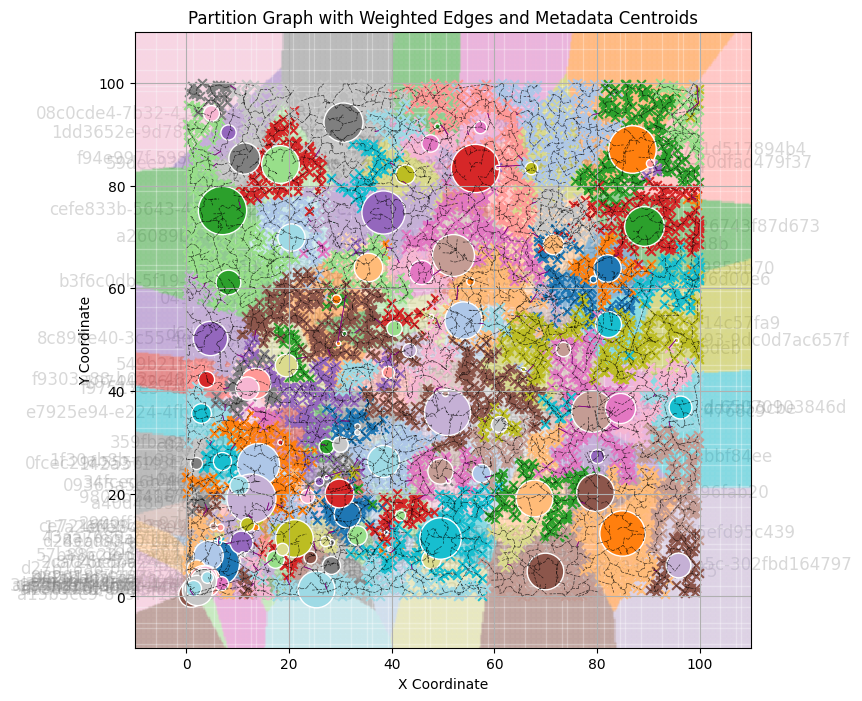

In [66]:
meta_data, partitions, edges, inter_edges = get_data()
clusters = get_clusters(0.1)

frames_data.append((meta_data, partitions, edges, inter_edges, clusters))

# # plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])
plot_partition_graph(partitions, edges, meta_data, inter_edges)

0.2
241


C:\Users\hasin\AppData\Local\Temp\ipykernel_58964\957809933.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\hasin\AppData\Local\Temp\ipykernel_58964\957809933.py:67: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

C:\Users\hasin\AppData\Local\Temp\ipykernel_58964\957809933.py:82: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



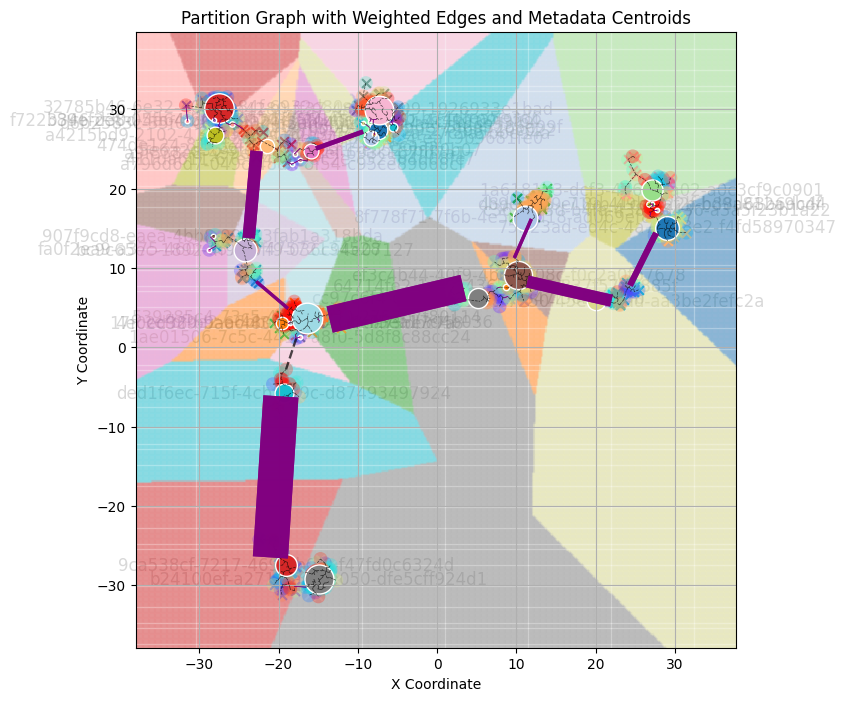

0.30000000000000004
151


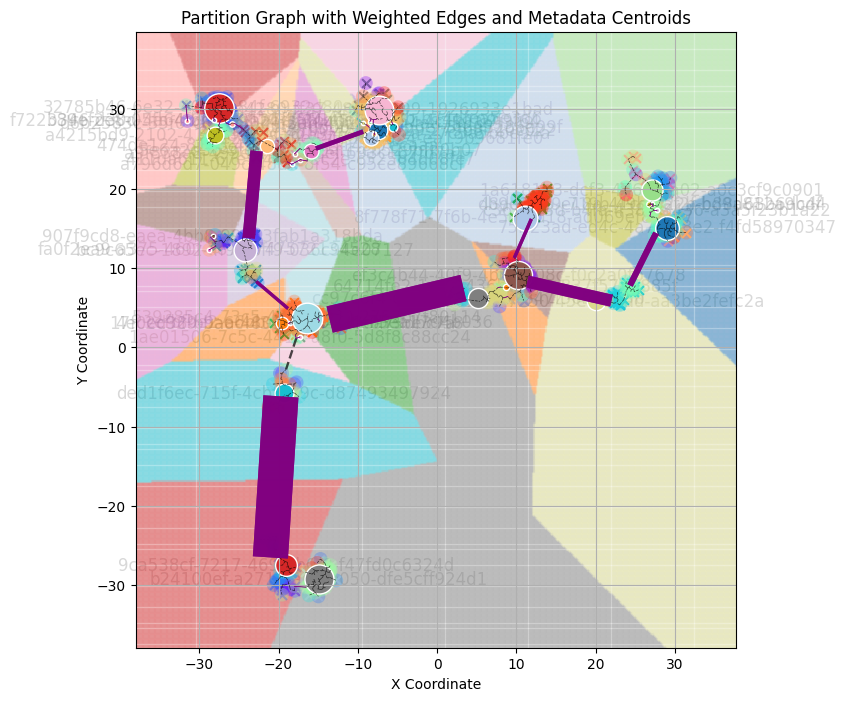

0.4
113


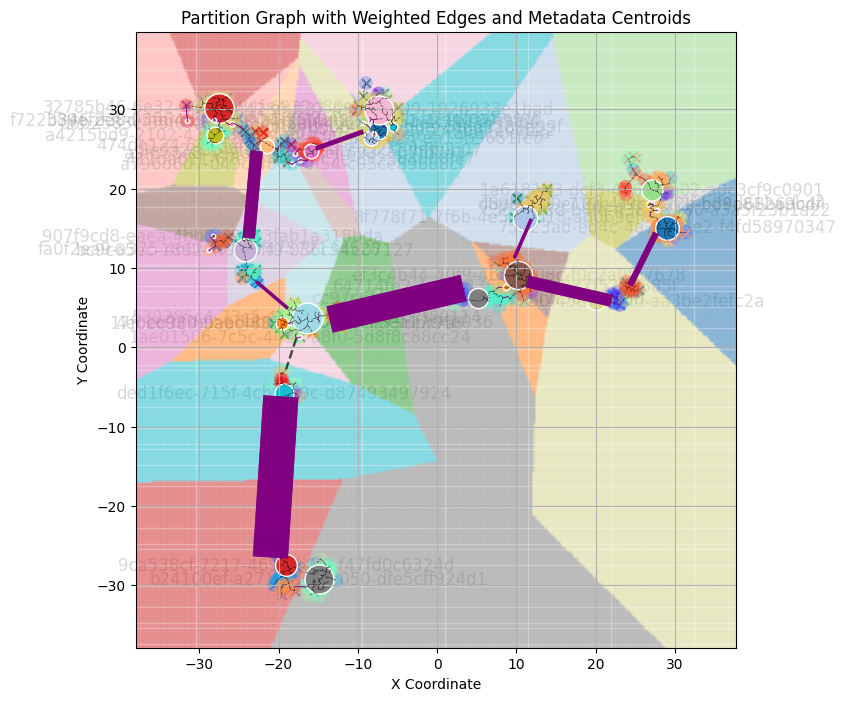

0.5
80


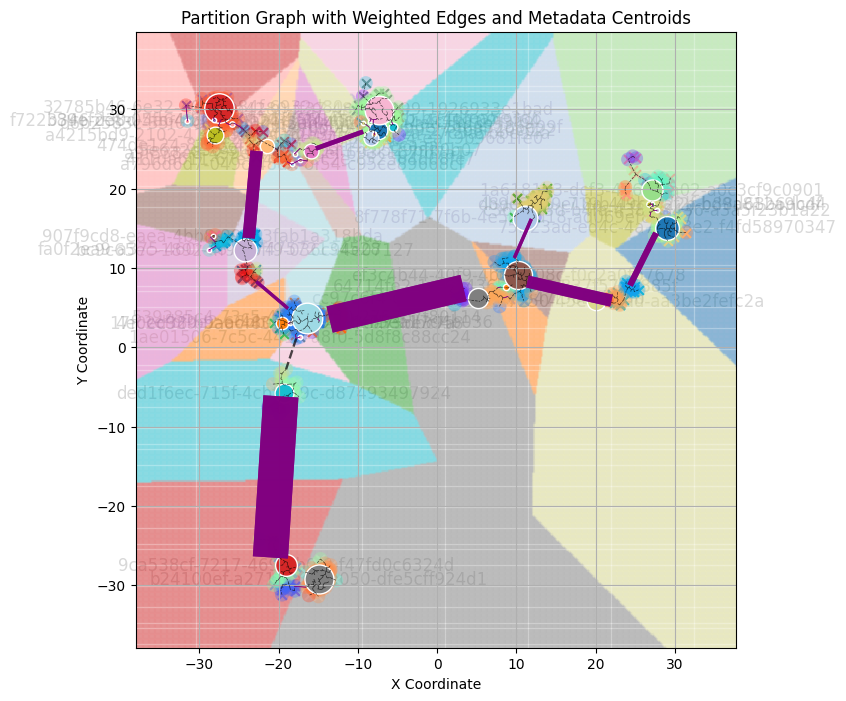

0.6
69


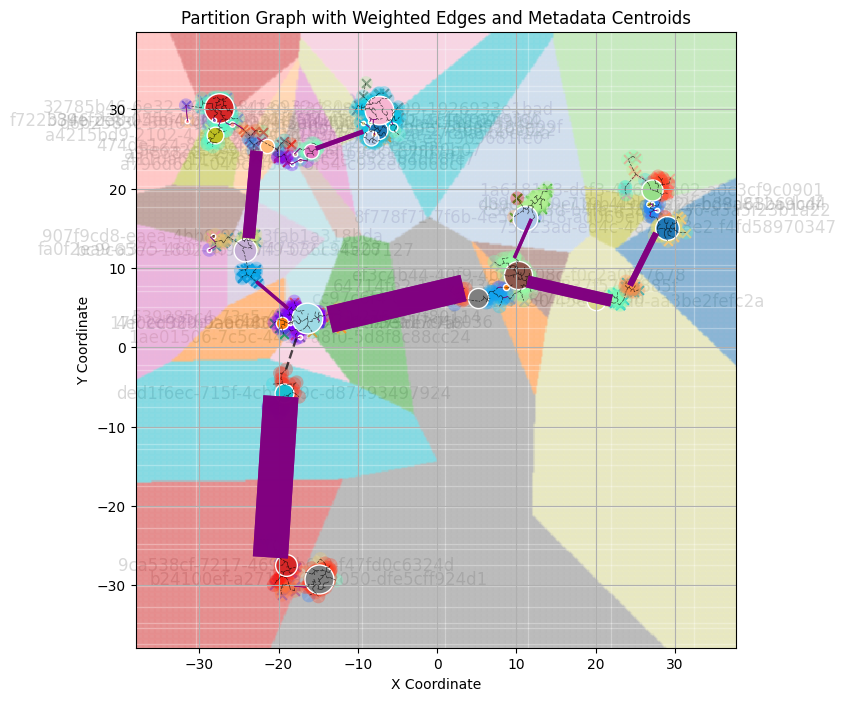

0.7
56


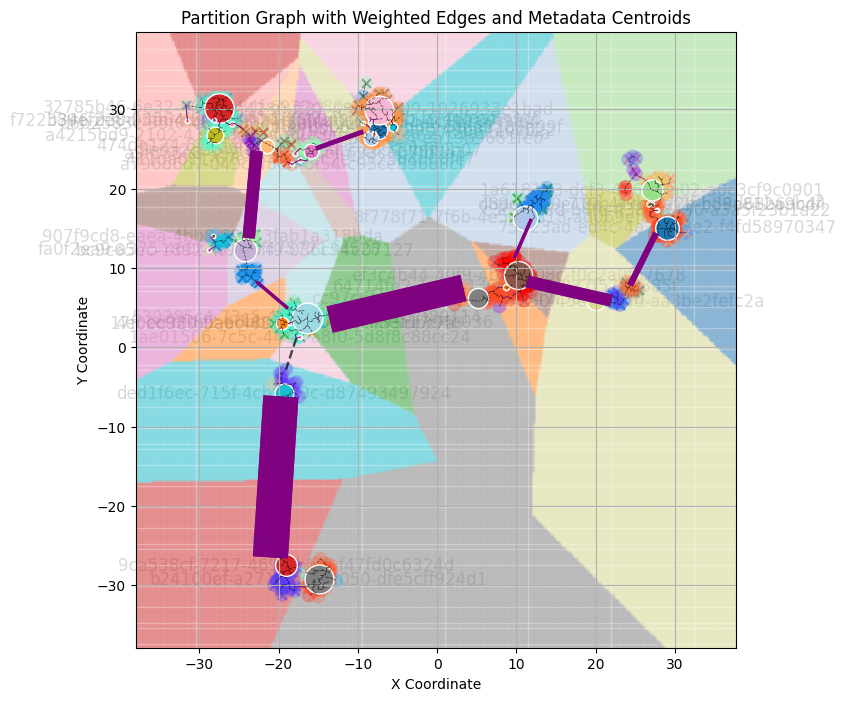

0.7999999999999999
43


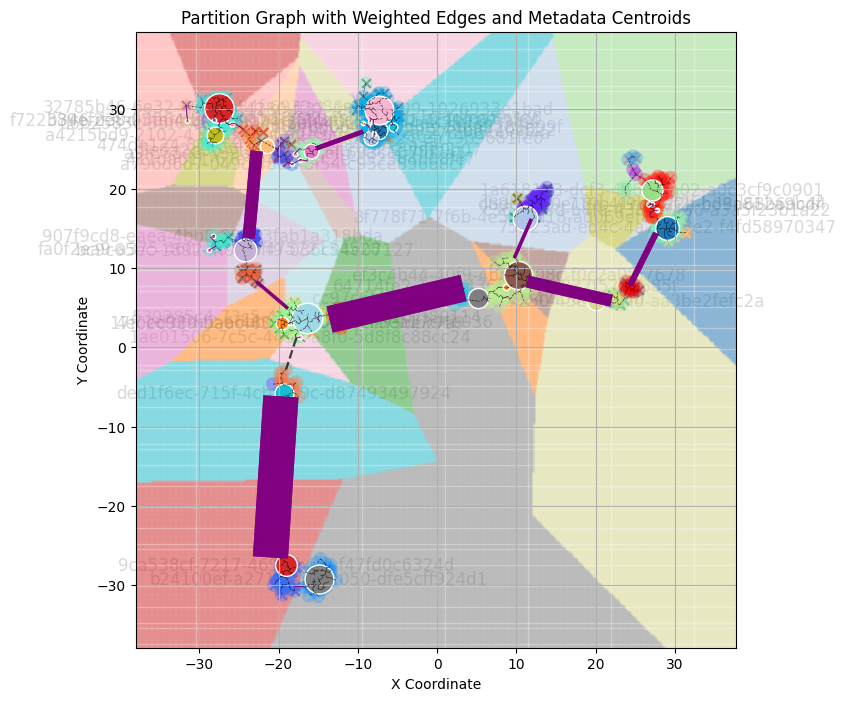

0.8999999999999999
37


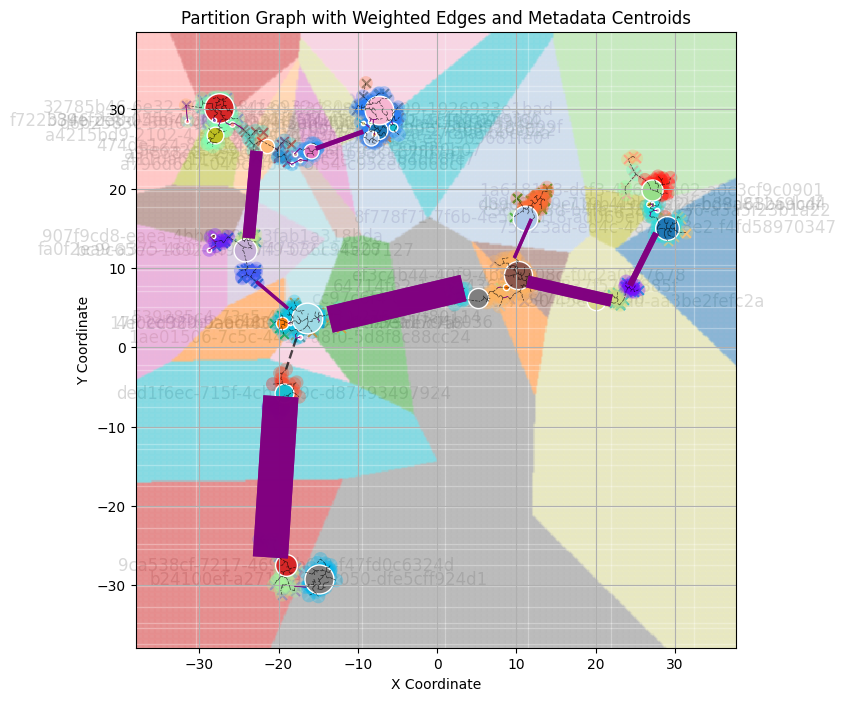

1.0
35


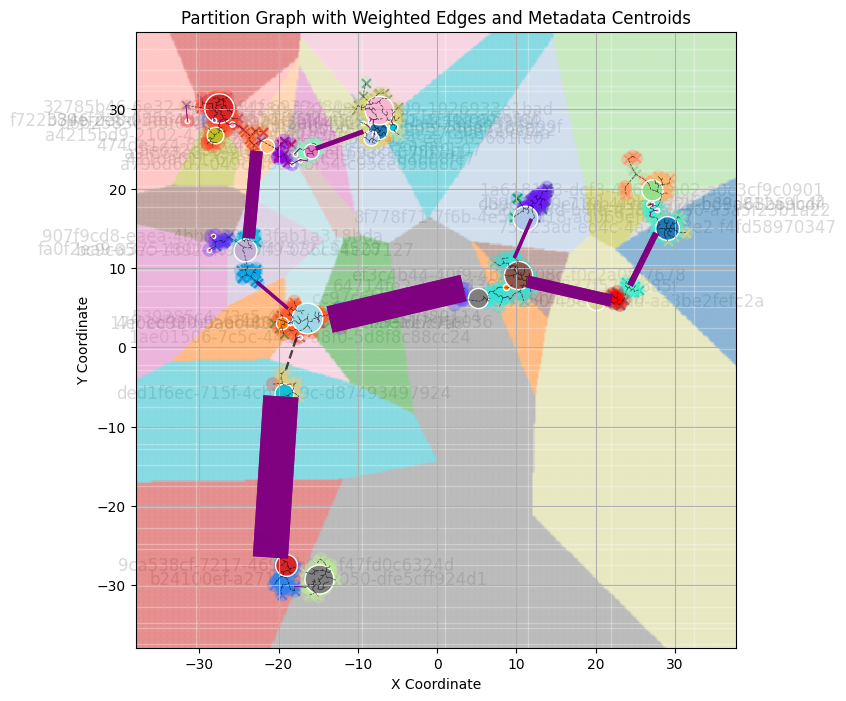

1.1
33


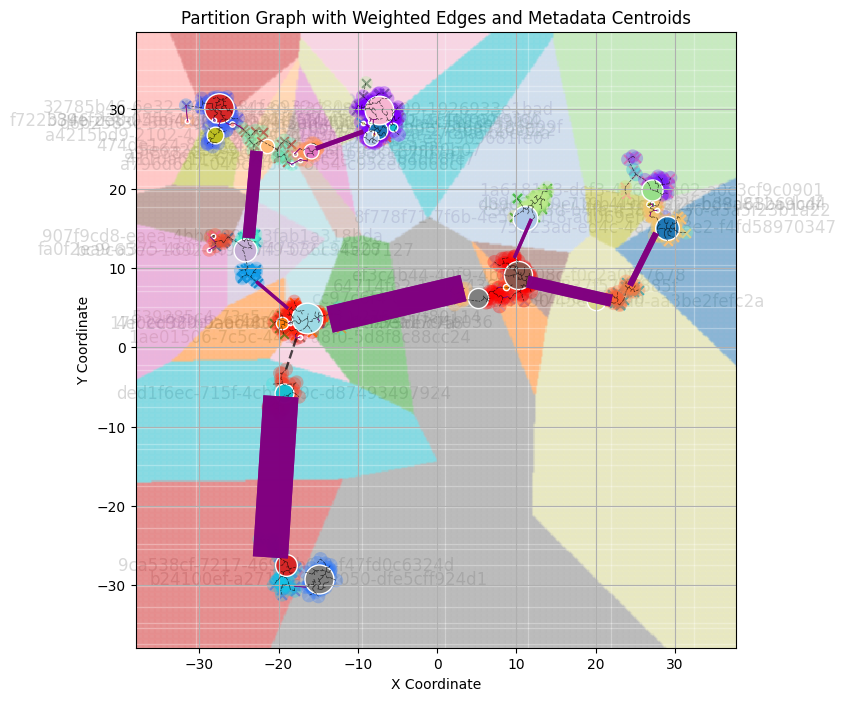

In [86]:
meta_data, partitions, edges, inter_edges = get_data()

for i in range(10):
    threshold = 0.1 + (float(i)/10. + 0.1)

    generate_clusters(threshold)
    
    clusters = get_clusters(threshold)

    print(threshold)
    print(len(clusters["clusters"]))

    frames_data.append((meta_data, partitions, edges, inter_edges, clusters))

    plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])

In [111]:
import sqlite3

# Step 1: Load benchmark data
conn = sqlite3.connect("benchmark_logs.db")
cursor = conn.cursor()
data = cursor.execute("SELECT id, start, end - start FROM benchmark WHERE parent_id IS NULL AND message='Insert Vector' ORDER BY start ASC")

rows = [x for x in data]

cursor.close()
conn.close()

rows

[('9a5cf018-4a93-46b1-a9fb-7fb989ab58d6', 1744753202241, 150),
 ('7521e06d-6261-4a43-8f64-a06f1e48ba5b', 1744753202392, 93),
 ('7a24b0ae-65da-4c33-8d6b-3288c403d2a2', 1744753202486, 92),
 ('405425fb-83cb-4d13-b308-e2aaedbd78da', 1744753202579, 205),
 ('4d1d9b3d-75ae-4f69-af07-356e56def87d', 1744753202785, 186),
 ('3aa73502-878a-4cf2-a15c-6d503a7bb97c', 1744753202972, 381),
 ('2443f9e7-f836-4583-ae58-a0f1aa28f6c5', 1744753203354, 186),
 ('298443d2-0b9d-4a15-9f58-ea66e42f9429', 1744753203541, 186),
 ('ca2b8917-945e-4655-9096-370ffab79434', 1744753203728, 130),
 ('9bf42487-5517-4650-b669-2f47cefe894e', 1744753203859, 350),
 ('52534056-5f17-41ea-acc9-5bf822b1eb35', 1744753204210, 242),
 ('8fc3cbdc-7713-4a25-bc4c-6a77016a25fe', 1744753204453, 299),
 ('c40b8851-ab31-4358-b7c6-8565c4152bcc', 1744753204752, 205),
 ('8d2ccdc6-4ce7-4492-9194-1cae49f21520', 1744753204958, 280),
 ('a7bee721-10e2-4082-8acd-b0bae4e4e6ed', 1744753205238, 383),
 ('0e579633-cd23-469b-aea6-5caf1b0e1a5a', 1744753205621, 

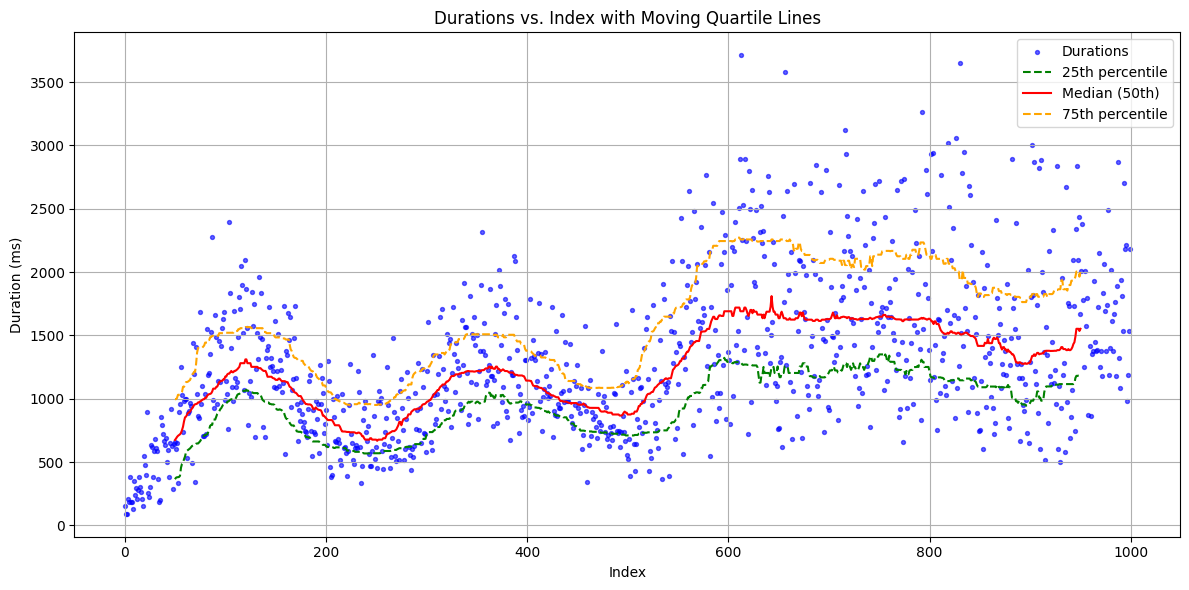

In [108]:
durations = [entry[2] for entry in rows]
indices = list(range(len(rows)))

import pandas as pd

# Plotting
df = pd.DataFrame({'index': indices, 'duration': durations})

# Set rolling window size (adjust as needed)
window_size = 100

# Compute moving quartiles
rolling_25 = df['duration'].rolling(window=window_size, center=True).quantile(0.25)
rolling_50 = df['duration'].rolling(window=window_size, center=True).quantile(0.5)
rolling_75 = df['duration'].rolling(window=window_size, center=True).quantile(0.75)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(df['index'], df['duration'], s=8, color='blue', alpha=0.6, label='Durations')

# Add moving quartile lines
plt.plot(df['index'], rolling_25, color='green', linestyle='--', label='25th percentile')
plt.plot(df['index'], rolling_50, color='red', linestyle='-', label='Median (50th)')
plt.plot(df['index'], rolling_75, color='orange', linestyle='--', label='75th percentile')

plt.xlabel("Index")
plt.ylabel("Duration (ms)")
plt.title("Durations vs. Index with Moving Quartile Lines")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [113]:
cursor.close()

ProgrammingError: Cannot operate on a closed database.

In [39]:
all_edges = []

for e in edges:
    all_edges+=e

all_edges.extend(inter_edges)

all_edges

[['cab933e7-c5e3-4b4f-82f8-e67ca694cfe8',
  '81af4f76-cffa-4d66-8949-c30e253e7a73',
  4.4714343e-05],
 ['eeba55bd-1f1d-4d9d-ae9f-26d0fbcb6a64',
  '6244fe58-34bd-41ca-83aa-e87f4eea57a5',
  2.6199961e-05],
 ['25ee401f-f067-42dd-87fb-5ae760c13c6d',
  '007be022-a7d9-4142-a5e6-7b966293020b',
  3.5504694e-05],
 ['e05f12f0-a286-42d8-9471-04453be1da98',
  '2d203171-8eb6-4c8f-8721-cb27ffa6f3e1',
  0.00013543275],
 ['6adbc791-c6d5-4c8b-8f39-c35efb2d4a49',
  '3a2394fb-b230-468b-aee4-e24fb4d04cf7',
  3.1957832e-05],
 ['2566bbf4-a849-4eea-923b-fc9a273a9632',
  '81af4f76-cffa-4d66-8949-c30e253e7a73',
  3.6375815e-05],
 ['6572e2f1-30d0-4233-bbbd-ccf4a6eb6b59',
  'bdd60546-f3ff-4001-8ed5-d065a60d8469',
  1.2948902e-05],
 ['56d2ed43-ad54-4648-96a6-9fa60b90a0f5',
  '25ee401f-f067-42dd-87fb-5ae760c13c6d',
  2.9606132e-05],
 ['2af80b48-1e0f-4b72-af91-ba9de6e2cf16',
  '6330b367-a51f-4091-8ae2-64b0aff7a499',
  5.9844297e-05],
 ['d8f3036d-d73e-495c-8ece-fd37969a6ca3',
  'eeba55bd-1f1d-4d9d-ae9f-26d0fbcb6a64'

In [40]:
from collections import defaultdict

def is_graph_connected(edges):
    if not edges:
        return False  # No edges, not connected
    
    # Build adjacency list
    graph = defaultdict(set)
    for u, v, _ in edges:
        graph[u].add(v)
        graph[v].add(u)
    
    # Perform BFS or DFS to check connectivity
    start = next(iter(graph))  # Pick any starting node
    visited = set()
    stack = [start]
    
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            stack.extend(graph[node] - visited)
    
    return len(visited) == len(graph)

is_graph_connected(all_edges)

True

In [99]:
generate_clusters(0.3)

False

In [100]:
clusters = get_clusters(0.5)

In [101]:
clusters["clusters"]

{'6bfe6403-d23c-43e7-8143-057b42dc4f46': ['615fe9bf-1dc0-4012-b5e8-2a36c951957e',
  '2a4d8827-62f6-4751-af27-cfa136e47dc0',
  '38a6c2cc-aac9-4c1e-92f5-4ca57e13fc68',
  '6ce2f2dc-e59e-4e99-8c96-329df84d7b56',
  'f2c7bb96-1fd2-40ee-ad9c-0bf3c84865b8',
  '47c32822-b596-4c20-85f2-759c0f15f877',
  '0620756d-0698-4795-834c-bbdbe063b191',
  '1621a0ef-3a64-4410-8e54-49d91ac341fa',
  'e9873c26-e8e9-4fa7-ad17-97d9c9c00766',
  'ff08c183-d678-4cf0-b7d7-a2104a6181cb',
  '13e6901f-ce15-4f09-8295-6ecd1a8c2644',
  'b8f383c2-8c3b-486e-84bb-9c252530f29a',
  '8411ba8b-61ed-482e-8276-0165904693db',
  '839dcd46-315e-4eb3-a68d-442a89d589be',
  'f145f013-6c59-4cb1-ae06-f57fc39c95f8',
  'a5eb6466-3610-415f-8363-1e0f6d5886a7',
  '7c1baa38-d110-473f-ad1c-97353cac94ca',
  '77440c5d-883f-4f6d-bbd3-fcea56425292',
  '06b791e4-8612-4dc6-af35-b0dbcb316dca',
  '3db45366-dcdb-475c-b5c6-ab1d3e3d330c',
  'efe8ce42-960d-498e-bca8-a1ae4b881784',
  '661346f9-eebd-4769-8e69-da0970878a33',
  'd0cd21bd-6c26-4a90-88b5-c056b8139

In [ ]:
# meta_data = get_metadata()
# partitions = get_vectors_by_partition(seq(meta_data).map(lambda x: x[0]).list())
# edges = seq(partitions).map(lambda x: get_edges_for_partition(x[0])).list()
# inter_edges = seq(partitions).map(lambda x: get_inter_edges_for_partition(x[0])).flatten().list()


meta_data, partitions, edges, inter_edges = get_data()


# Create a figure for the final frame
fig: Figure = plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\1394646879.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_partitions)
C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\1394646879.py:67: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
C:\Users\hasin\AppData\Local\Temp\ipykernel_29392\1394646879.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('rainbow', len(cluster_data))


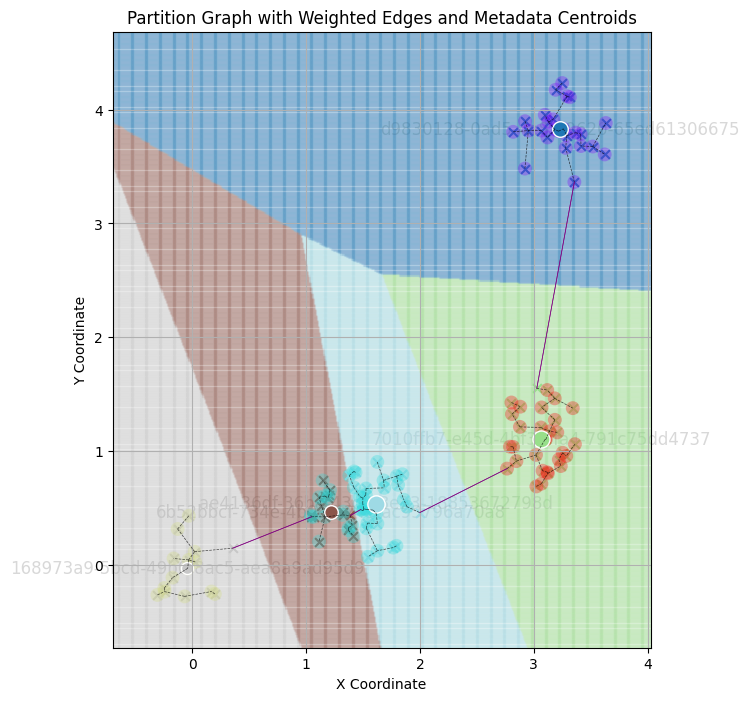

In [ ]:
plot_partition_graph(partitions, edges, meta_data, inter_edges, clusters["clusters"])

In [ ]:
vectors[11]

[0.4691366163130478, 0.4915732838146507]

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x0000025AFE54EAC0> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'Figure' object is not iterable

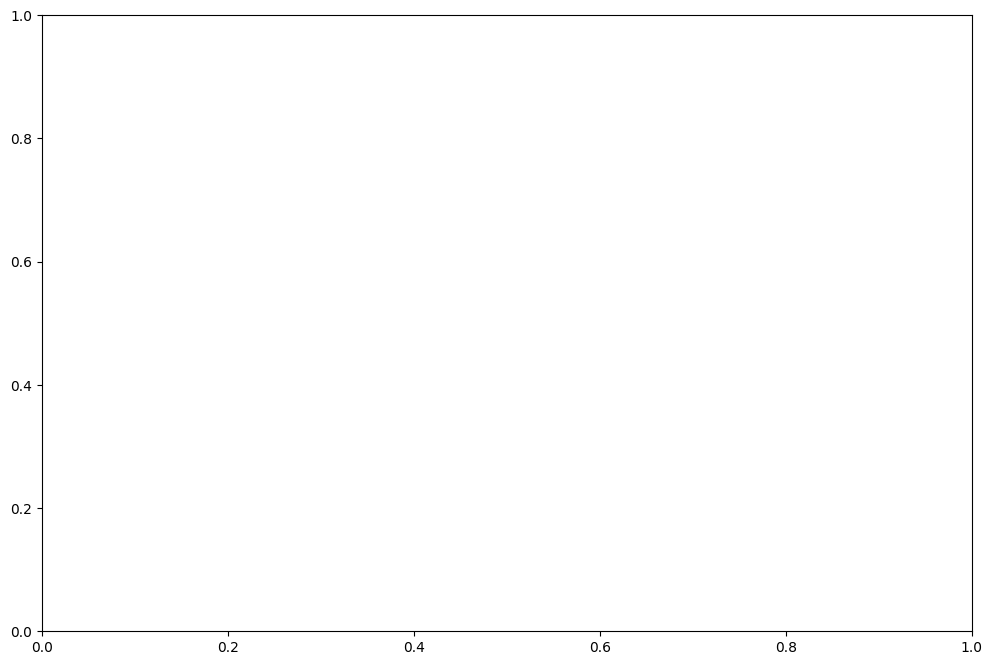

In [87]:

# Create an animation and save it as a GIF
fig, ax = plt.subplots(figsize=(12, 8))
def update_frame(i):
    ax.clear()
    plot_partition_graph(partitions, edges, meta_data, inter_edges)

ani = animation.ArtistAnimation(fig, frames, interval=500, repeat_delay=1000)
ani.save('partition_graph_animation.gif', writer='pillow')


In [ ]:
clusters

[Cluster(center=[0.1, 0.1], radius=0.05, num_points=100),
 Cluster(center=[0.7, 0.7], radius=0.2, num_points=30),
 Cluster(center=[0.4, 0.4], radius=0.15, num_points=50),
 Cluster(center=[0.9, 0.1], radius=0.1, num_points=80)]

In [ ]:

composite_cluster_centers

[[0.5, 0.5], [0.55, 0.55], [0.5, 0.6], [0.45, 0.55]]

In [ ]:
knn_query([3.,3.1], 40)

Response from '/knn': [("4bd2077a-3f7b-4b9e-82fb-3f6c59e13ae6", 0.06692436), ("19544792-e484-4dbe-8a36-85dc8468add8", 0.070927694), ("e0ef583e-c7c7-4b81-84f6-8ec7e3e93fa3", 0.10130589), ("5befcfe8-28f6-4140-9564-8a5b0db4e61f", 0.12982829), ("ea494ac0-46e7-4ee9-b6c5-aebdac735bc6", 0.15341382), ("6e4683f5-60a3-44c6-baee-d4762ea38dc5", 0.19784907), ("64632002-a280-4a8c-ade8-ad30ed481d1a", 0.23400816), ("043de385-b482-494d-ac18-fa3f7833dc52", 0.24140593), ("603f659f-a544-418a-b4a1-7726ddd59901", 0.24904238), ("94ee6dba-fca2-4ec0-a1e6-fdaf7ee89fea", 0.27426243), ("f4637e83-17a5-4002-a75e-18dbc0a48ab1", 0.32900795), ("e1ccc704-86c0-46da-94ba-a077261baee6", 0.36173552), ("8b5be516-8d47-4849-93cb-b996bbba2e20", 0.38943243), ("9377481f-3146-4864-adf5-216ea3559a09", 0.26793686), ("03ff4b9a-0a3e-4739-b64b-9a324adf8e2d", 0.30065754), ("2bc3c7a7-0eb7-4094-9796-d221df65f7cd", 0.33012173), ("41b9da52-8ecf-4f58-a113-3272c1d84a79", 0.34122235), ("382b902b-24e6-4d0f-87c0-4e134eebcdb9", 0.35944346), ("fc

'[("4bd2077a-3f7b-4b9e-82fb-3f6c59e13ae6", 0.06692436), ("19544792-e484-4dbe-8a36-85dc8468add8", 0.070927694), ("e0ef583e-c7c7-4b81-84f6-8ec7e3e93fa3", 0.10130589), ("5befcfe8-28f6-4140-9564-8a5b0db4e61f", 0.12982829), ("ea494ac0-46e7-4ee9-b6c5-aebdac735bc6", 0.15341382), ("6e4683f5-60a3-44c6-baee-d4762ea38dc5", 0.19784907), ("64632002-a280-4a8c-ade8-ad30ed481d1a", 0.23400816), ("043de385-b482-494d-ac18-fa3f7833dc52", 0.24140593), ("603f659f-a544-418a-b4a1-7726ddd59901", 0.24904238), ("94ee6dba-fca2-4ec0-a1e6-fdaf7ee89fea", 0.27426243), ("f4637e83-17a5-4002-a75e-18dbc0a48ab1", 0.32900795), ("e1ccc704-86c0-46da-94ba-a077261baee6", 0.36173552), ("8b5be516-8d47-4849-93cb-b996bbba2e20", 0.38943243), ("9377481f-3146-4864-adf5-216ea3559a09", 0.26793686), ("03ff4b9a-0a3e-4739-b64b-9a324adf8e2d", 0.30065754), ("2bc3c7a7-0eb7-4094-9796-d221df65f7cd", 0.33012173), ("41b9da52-8ecf-4f58-a113-3272c1d84a79", 0.34122235), ("382b902b-24e6-4d0f-87c0-4e134eebcdb9", 0.35944346), ("fc055467-0f2b-48e7-97fe

In [74]:
from collections import defaultdict, deque

def build_graph(edges):
    graph = defaultdict(list)
    for u, v in edges:
        graph[u].append(v)
        graph[v].append(u)
    return graph

def bfs(start, graph, visited):
    queue = deque([start])
    component = []
    while queue:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)
            component.append(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    queue.append(neighbor)
    return component

def check_connected_or_get_components(edges):
    if not edges:
        return True, []

    graph = build_graph(edges)
    visited = set()
    components = []

    for node in graph:
        if node not in visited:
            component = bfs(node, graph, visited)
            components.append(component)

    is_connected = len(components) == 1
    return is_connected, components if not is_connected else None

# Example usage:
edges = [(8, 18), (22, 21), (17, 11), (3, 1), (13, 10), (27, 18), (23, 19), (21, 9), (16, 2), (32, 8), (1, 2), (23, 7), (1, 10), (4, 18), (31, 2), (29, 15), (34, 29), (9, 14), (17, 9), (10, 12), (4, 20), (22, 20), (3, 23), (25, 24), (24, 23), (26, 24), (0, 28), (29, 14), (28, 27), (30, 27), (7, 5), (16, 17), (33, 8)]
connected, result = check_connected_or_get_components(edges)

if connected:
    print("Graph is connected.")
else:
    print("Graph is NOT connected. Components:")
    for comp in result:
        print(comp)


Graph is connected.
